##### Importación de librerías

In [1]:
import librosa
import librosa.display
import tqdm
import os
import scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import dtale as dt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

----

##### Lectura de los datasets

In [2]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos de los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv"

In [3]:
def listar_archivos(directorio, nivel=0, max_nivel=None):
    contenidos = os.listdir(directorio)
    for contenido in contenidos[:3]:
        ruta_contenido = os.path.join(directorio, contenido)
        print(' ' * (nivel * 4) + '|-- ' + contenido)
        if os.path.isdir(ruta_contenido):
            listar_archivos(ruta_contenido, nivel + 1, max_nivel)

# Llamada a la función
listar_archivos(urbansound8k_path + urbansound8k_audio_path)

|-- .DS_Store
|-- fold1
    |-- .DS_Store
    |-- 101415-3-0-2.wav
    |-- 101415-3-0-3.wav
|-- fold10
    |-- .DS_Store
    |-- 100648-1-0-0.wav
    |-- 100648-1-1-0.wav


In [4]:
metadata_urbansound8k_df = pd.read_csv( urbansound8k_path + urbansound8k_metadata_path_file, sep=",")
display(metadata_urbansound8k_df.head(1))

slice_file_name    fsID  start       end  salience  fold  classID  \
0  100032-3-0-0.wav  100032    0.0  0.317551         1     5        3   

      class  
0  dog_bark

----

##### Descripción de los datasets

In [5]:
def contar_archivos_por_extension(directorio, nivel=0, max_nivel=None):
    if max_nivel is not None and nivel > max_nivel:
        return defaultdict(int)
    
    # Diccionario para contar extensiones
    conteo_extensiones = defaultdict(int)
    contenidos = os.listdir(directorio)
    
    for contenido in contenidos:
        ruta_contenido = os.path.join(directorio, contenido)
        
        if os.path.isfile(ruta_contenido):
            _, extension = os.path.splitext(contenido)
            conteo_extensiones[extension] += 1
        
        elif os.path.isdir(ruta_contenido):
            subconteo = contar_archivos_por_extension(ruta_contenido, nivel + 1, max_nivel)
            for ext, count in subconteo.items():
                conteo_extensiones[ext] += count

    print(' ' * (nivel * 4) + f"{directorio}: {dict(conteo_extensiones)}")

    return conteo_extensiones 

print("Conteo de archivos por extension")
conteo_global = contar_archivos_por_extension(urbansound8k_path + urbansound8k_audio_path)

Conteo de archivos por extension
    ../../data/raw/UrbanSound8K/audio/fold1: {'': 1, '.wav': 873}
    ../../data/raw/UrbanSound8K/audio/fold10: {'': 1, '.wav': 837}


    ../../data/raw/UrbanSound8K/audio/fold2: {'': 1, '.wav': 888}
    ../../data/raw/UrbanSound8K/audio/fold3: {'': 1, '.wav': 925}
    ../../data/raw/UrbanSound8K/audio/fold4: {'': 1, '.wav': 990}
    ../../data/raw/UrbanSound8K/audio/fold5: {'': 1, '.wav': 936}
    ../../data/raw/UrbanSound8K/audio/fold6: {'': 1, '.wav': 823}
    ../../data/raw/UrbanSound8K/audio/fold7: {'': 1, '.wav': 838}
    ../../data/raw/UrbanSound8K/audio/fold8: {'': 1, '.wav': 806}
    ../../data/raw/UrbanSound8K/audio/fold9: {'': 1, '.wav': 816}
../../data/raw/UrbanSound8K/audio/: {'': 11, '.wav': 8732}


In [6]:
def reporte_descripcion_dataset(df):
    columnas = df.columns
    print("Columnas del dataset:\n")
    for col in columnas:
        print(col)
    print(f"\nCantidad de filas: {df.shape[0]}")

In [7]:
print("Descripción del dataset 'metadata_urbansound8k_df'")
reporte_descripcion_dataset(metadata_urbansound8k_df)

Descripción del dataset 'metadata_urbansound8k_df'
Columnas del dataset:

slice_file_name
fsID
start
end
salience
fold
classID
class

Cantidad de filas: 8732


----

##### Carga de audio como una serie temporal 

In [9]:
# https://librosa.org/doc/0.10.2/generated/librosa.load.html#librosa.load

indice_archivo_audio_analisis = 5
nombre_archivo_audio = metadata_urbansound8k_df['slice_file_name'][indice_archivo_audio_analisis]
folder_archivo_audio = metadata_urbansound8k_df['fold'][indice_archivo_audio_analisis]
ruta_archivo_audio = f"{urbansound8k_path}/audio/fold{folder_archivo_audio}/{nombre_archivo_audio}"

serie_tiempo, tasa_muestreo_hz = librosa.load(ruta_archivo_audio, sr=None, mono=False)
print(f"Tasa de muestreo (hz) : {tasa_muestreo_hz}") 
print(f"Serie temporal de audio : {serie_tiempo}")
print(f"Número total de muestras : {serie_tiempo.shape}") 

plt.plot(serie_tiempo)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


Tasa de muestreo (hz) : 44100
Serie temporal de audio : [[0.00668335 0.00656128 0.00622559 ... 0.01028442 0.00976562 0.00949097]
 [0.00436401 0.00671387 0.00878906 ... 0.00125122 0.00216675 0.00280762]]
Número total de muestras : (2, 176400)


----

##### Obtención de metadatos a partir de lo archivos de audio

In [21]:
audio_duracion_list = []
audio_tasa_muestreo_list = []
audio_desplazamiento_dc_list = []
audio_cantidad_canales_list = []
audio_rango_dinamico_list = []
audio_energia_list = []
audio_tasa_cruce_cero_list = []
audio_entropia_espectograma_list = []
audio_centroide_espectral_list = [] 
audio_path_list = []

muestras_duracion_sumatoria = 0
for index, row in metadata_urbansound8k_df.iterrows():
    path_total_file = f"{urbansound8k_path}/audio/fold{row['fold']}/{row['slice_file_name']}"
    serie_tiempo, tasa_muestreo_hz = librosa.load(path_total_file, sr=None, mono=False)
    duracion_segundos = librosa.get_duration(y=serie_tiempo, sr=tasa_muestreo_hz) # Calcular la duración (en segundos) de una serie temporal de audio
    desplazamiento_dc = np.abs(np.mean(serie_tiempo)) # Desplazamiento de corriente continua (DC offset)
    cantidad_canales = len(serie_tiempo.shape)
    rango_dinamico = np.max(serie_tiempo) - np.min(serie_tiempo)
    energia = np.sum(serie_tiempo**2)

    zero_crossings = librosa.zero_crossings(serie_tiempo, pad=False)
    tasa_cruce_cero = np.sum(zero_crossings)

    spec = np.abs(librosa.stft(serie_tiempo))**2
    entropia_espectograma = scipy.stats.entropy(spec.flatten())

    spectral_centroids = librosa.feature.spectral_centroid(y=serie_tiempo, sr=tasa_muestreo_hz)[0]
    avg_centroide_espectral = np.mean(spectral_centroids)   

    audio_path_list.append(path_total_file)
    audio_duracion_list.append(duracion_segundos)
    audio_tasa_muestreo_list.append(tasa_muestreo_hz)
    audio_desplazamiento_dc_list.append(desplazamiento_dc)
    audio_cantidad_canales_list.append(cantidad_canales)
    audio_rango_dinamico_list.append(rango_dinamico)
    audio_energia_list.append(energia)
    audio_tasa_cruce_cero_list.append(tasa_cruce_cero)
    audio_entropia_espectograma_list.append(entropia_espectograma)
    audio_centroide_espectral_list.append(avg_centroide_espectral)    

metadata_urbansound8k_df['path'] = audio_path_list
metadata_urbansound8k_df['duracion'] = audio_duracion_list
metadata_urbansound8k_df['tasa_muestreo'] = audio_tasa_muestreo_list
metadata_urbansound8k_df['desplazamiento_dc'] = audio_desplazamiento_dc_list
metadata_urbansound8k_df['cantidad_canales'] = audio_cantidad_canales_list
metadata_urbansound8k_df['rango_dinamico'] = audio_rango_dinamico_list
metadata_urbansound8k_df['energia'] = audio_energia_list
metadata_urbansound8k_df['tasa_cruce_cero'] = audio_tasa_cruce_cero_list
metadata_urbansound8k_df['entropia_espectograma'] = audio_entropia_espectograma_list
metadata_urbansound8k_df['avg_centroide_espectral'] = audio_centroide_espectral_list 


###### Guardamos en un CSV unificado

In [22]:
metadata_urbansound8k_df.to_csv("../../data/processed/dataset_urbansound8k_v1.csv", sep=';', index=False)

In [23]:
dataset_urbansound8k_df = pd.read_csv("../../data/processed/dataset_urbansound8k_v1.csv", sep=";")

In [24]:
print("Descripción del dataset 'dataset_urbansound8k_df'")
reporte_descripcion_dataset(dataset_urbansound8k_df)

Descripción del dataset 'dataset_urbansound8k_df'
Columnas del dataset:

slice_file_name
fsID
start
end
salience
fold
classID
class
path
duracion
tasa_muestreo
desplazamiento_dc
cantidad_canales
rango_dinamico
energia
tasa_cruce_cero
entropia_espectograma
avg_centroide_espectral

Cantidad de filas: 8732


----

##### Exploración de metadatos

In [25]:
# Se usa la librería dtale para poder obtener una vista interactiva de los datos

# Dataset: metadatos de los audio + csv de metadatos
dataset_urbansound8k_dtale = dt.show(dataset_urbansound8k_df)
dataset_urbansound8k_dtale.open_browser()

----

##### Gráficos de interés

###### Clasificacion

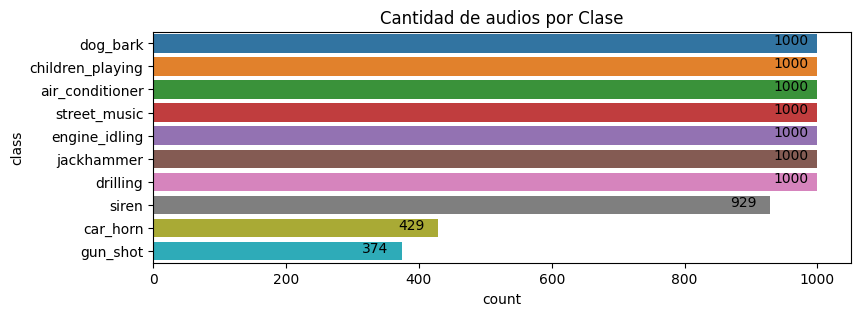

In [26]:
# Cantidad de audios por Clase
plt.figure(figsize=(9,3))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index,
              palette =sns.color_palette(n_colors=10))

for p in ax.patches:
    width = p.get_width()  # Anchura de la barra
    plt.text(width - 40,  # Posición en el eje x (ligeramente desplazado a la derecha)
             p.get_y() + p.get_height() / 3,  # Posición en el eje y
             int(width),  # El valor de la cantidad
             ha='center', va='center')  # Alineación del texto

plt.title("Cantidad de audios por Clase")
plt.show()

2024-08-21 09:11:53,801 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-21 09:11:53,829 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


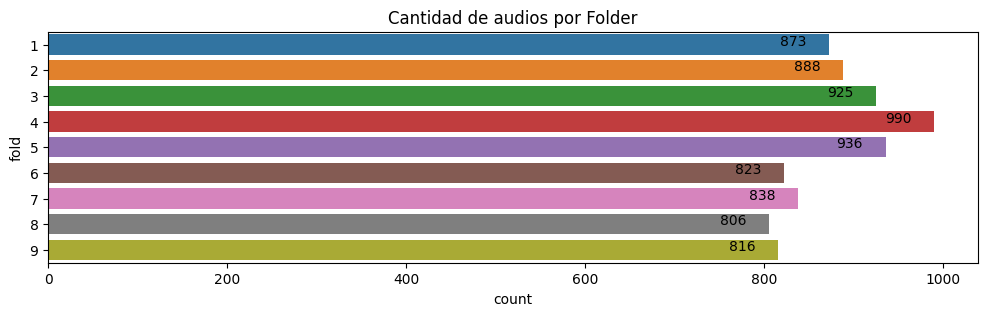

In [27]:
# Cantidad de audios por Folder
plt.figure(figsize=(12,3))
ax = sns.countplot(y=dataset_urbansound8k_df['fold'], 
              order=[num for num in range(1,10)],
              palette =sns.color_palette(n_colors=10))

for p in ax.patches:
    width = p.get_width()  # Anchura de la barra
    plt.text(width - 40,  # Posición en el eje x (ligeramente desplazado a la derecha)
             p.get_y() + p.get_height() / 3,  # Posición en el eje y
             int(width),  # El valor de la cantidad
             ha='center', va='center')  # Alineación del texto

plt.title("Cantidad de audios por Folder")
plt.show()

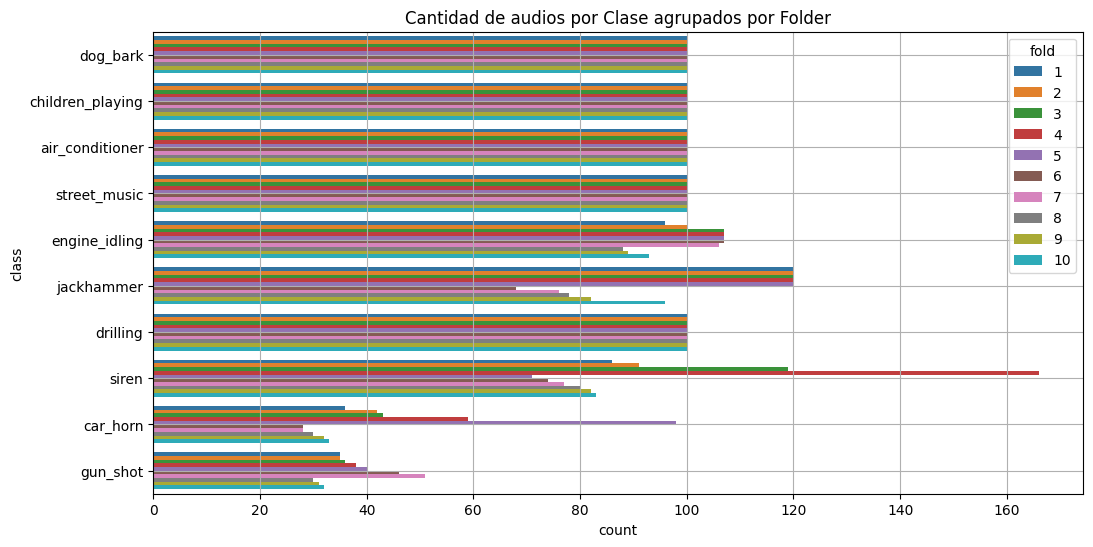

In [28]:
# Cantidad de audios por Clase agrupados por Folder
plt.figure(figsize=(12,6))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index, 
              hue=dataset_urbansound8k_df['fold'],
              palette =sns.color_palette(n_colors=10)) 

plt.title("Cantidad de audios por Clase agrupados por Folder")
plt.grid()
plt.show()


###### Distribución

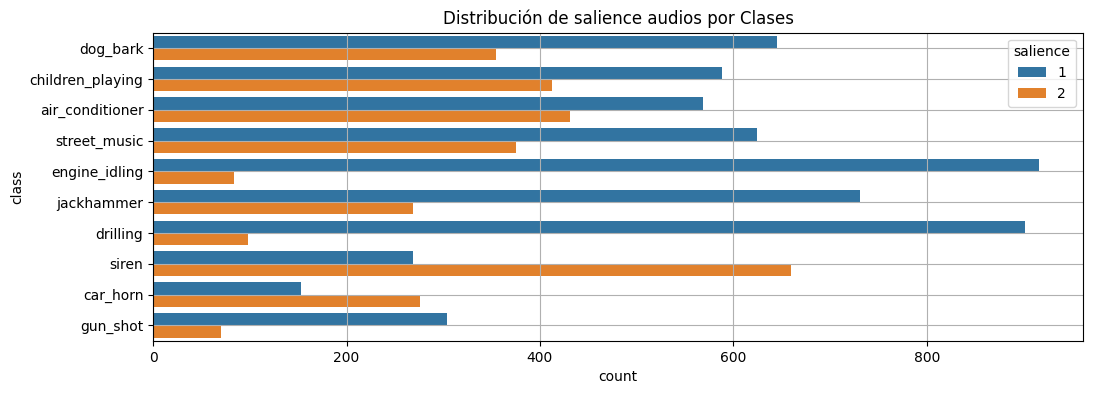

In [29]:
# Distribución de salience audios por Clases
plt.figure(figsize=(12,4))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index, 
              hue=dataset_urbansound8k_df['salience'],
              palette =sns.color_palette(n_colors=10)) 
plt.title("Distribución de salience audios por Clases")
plt.grid()
plt.show()

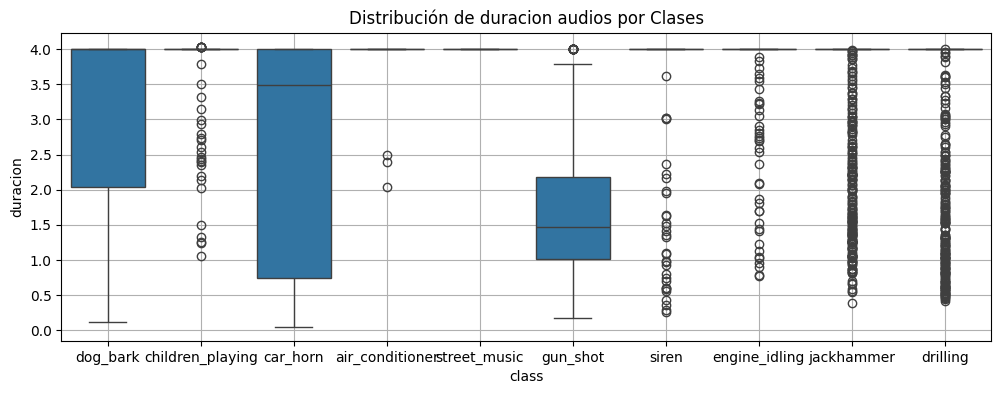

In [30]:
# Distribución de duracion audios por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['duracion'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de duracion audios por Clases")
plt.grid()
plt.show()

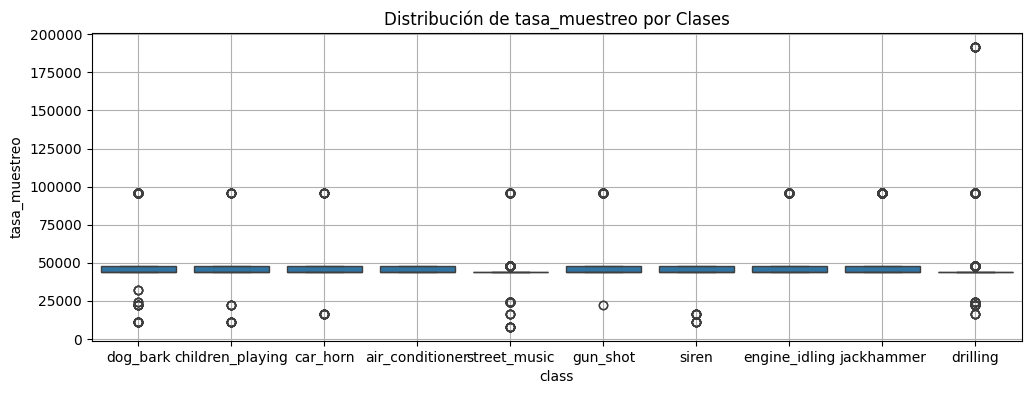

In [31]:
# Distribución de tasa_muestreo por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['tasa_muestreo'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de tasa_muestreo por Clases")
plt.grid()
plt.show()

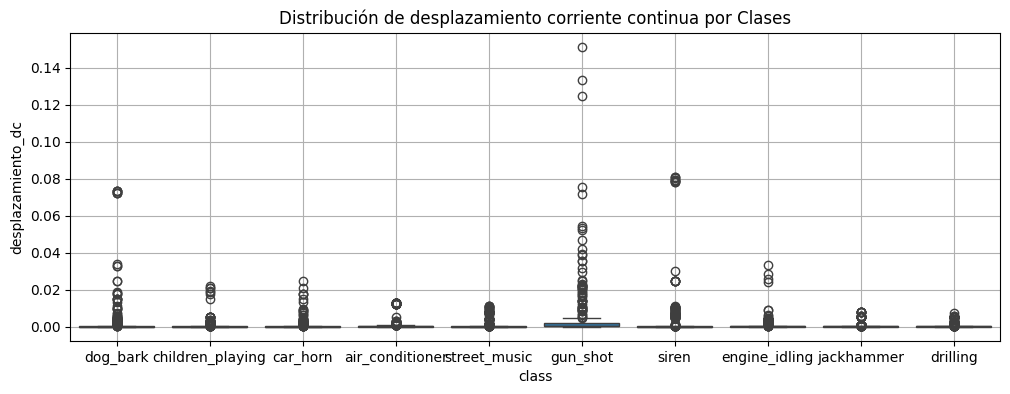

In [32]:
# Distribución de desplazamiento corriente continua por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['desplazamiento_dc'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de desplazamiento corriente continua por Clases")
plt.grid()
plt.show()

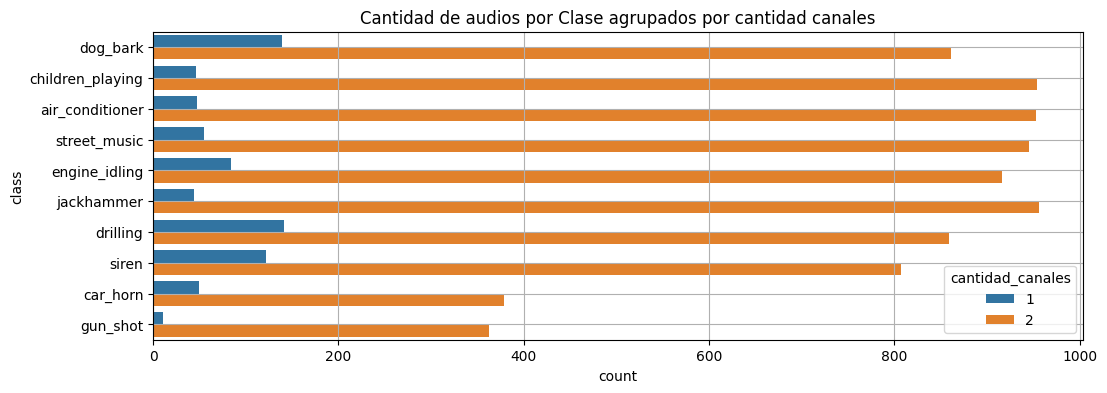

In [33]:
# Cantidad de audios por Clase agrupados por cantidad canales
plt.figure(figsize=(12,4))
ax = sns.countplot(y=dataset_urbansound8k_df['class'], 
              order=dataset_urbansound8k_df['class'].value_counts().index, 
              hue=dataset_urbansound8k_df['cantidad_canales'],
              palette =sns.color_palette(n_colors=10)) 

plt.title("Cantidad de audios por Clase agrupados por cantidad canales")
plt.grid()
plt.show()


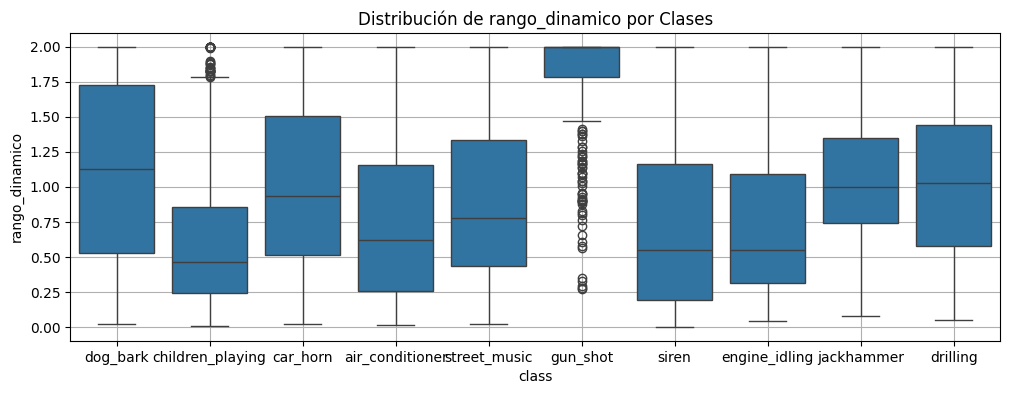

In [34]:
# Distribución de rango_dinamico por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['rango_dinamico'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de rango_dinamico por Clases")
plt.grid()
plt.show()

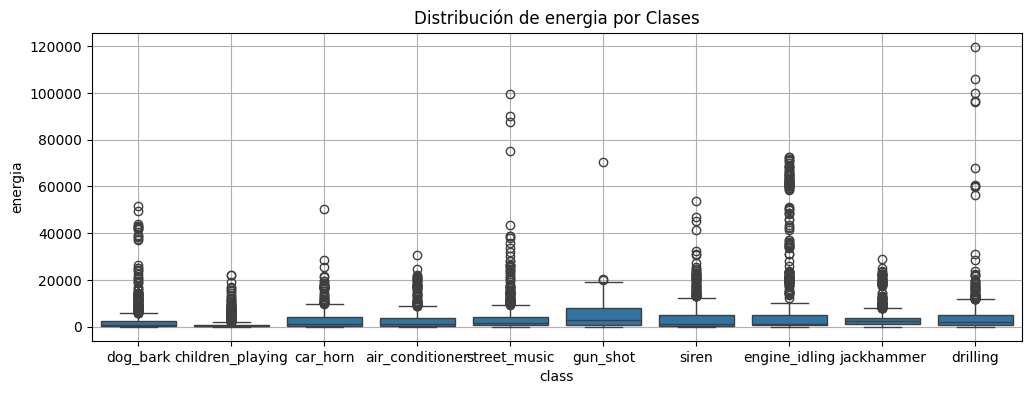

In [35]:
# Distribución de energia por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['energia'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de energia por Clases")
plt.grid()
plt.show()

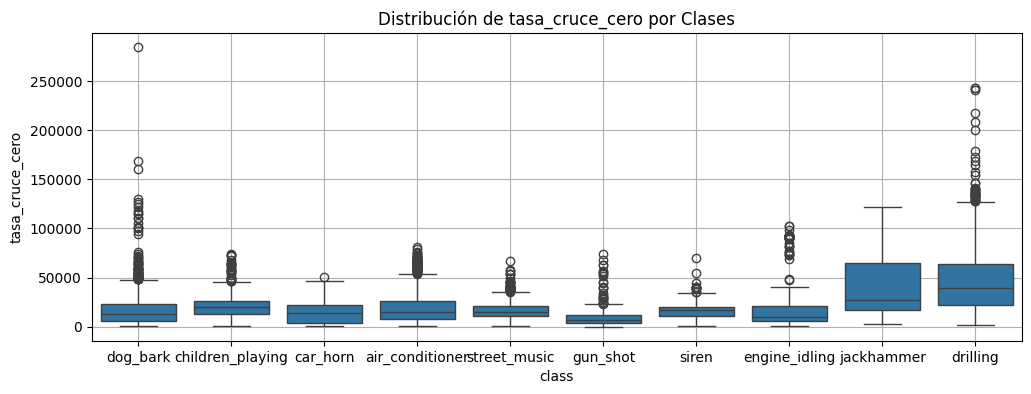

In [36]:
# Distribución de tasa_cruce_cero por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['tasa_cruce_cero'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de tasa_cruce_cero por Clases")
plt.grid()
plt.show()

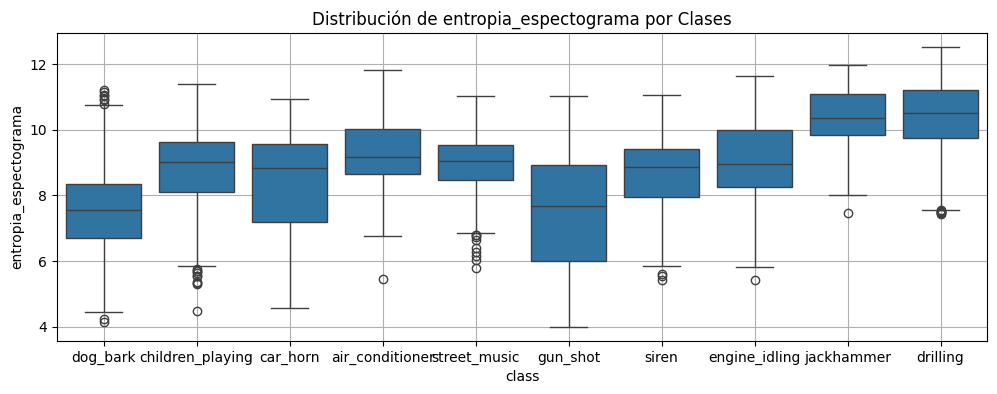

In [37]:
# Distribución de entropia_espectograma por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['entropia_espectograma'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de entropia_espectograma por Clases")
plt.grid()
plt.show()

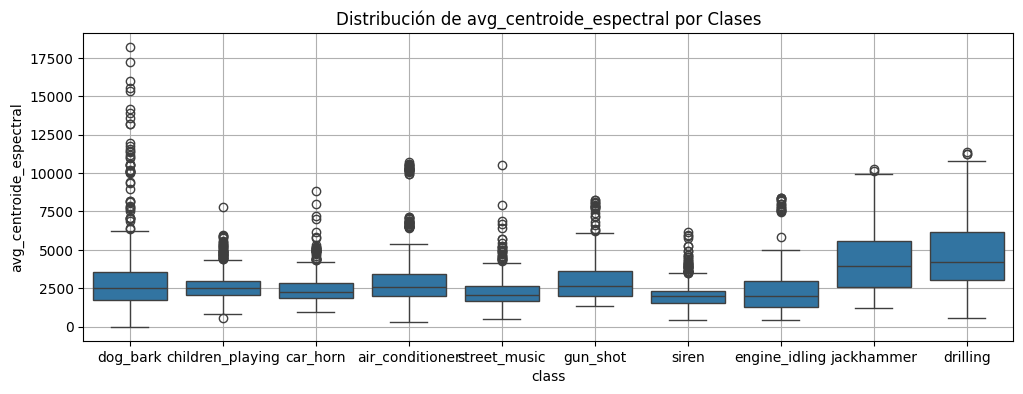

In [38]:
# Distribución de avg_centroide_espectral por Clases
plt.figure(figsize=(12,4))
ax = sns.boxplot(y=dataset_urbansound8k_df['avg_centroide_espectral'], x=dataset_urbansound8k_df['class']) 
plt.title("Distribución de avg_centroide_espectral por Clases")
plt.grid()
plt.show()

###### Grafico de onda

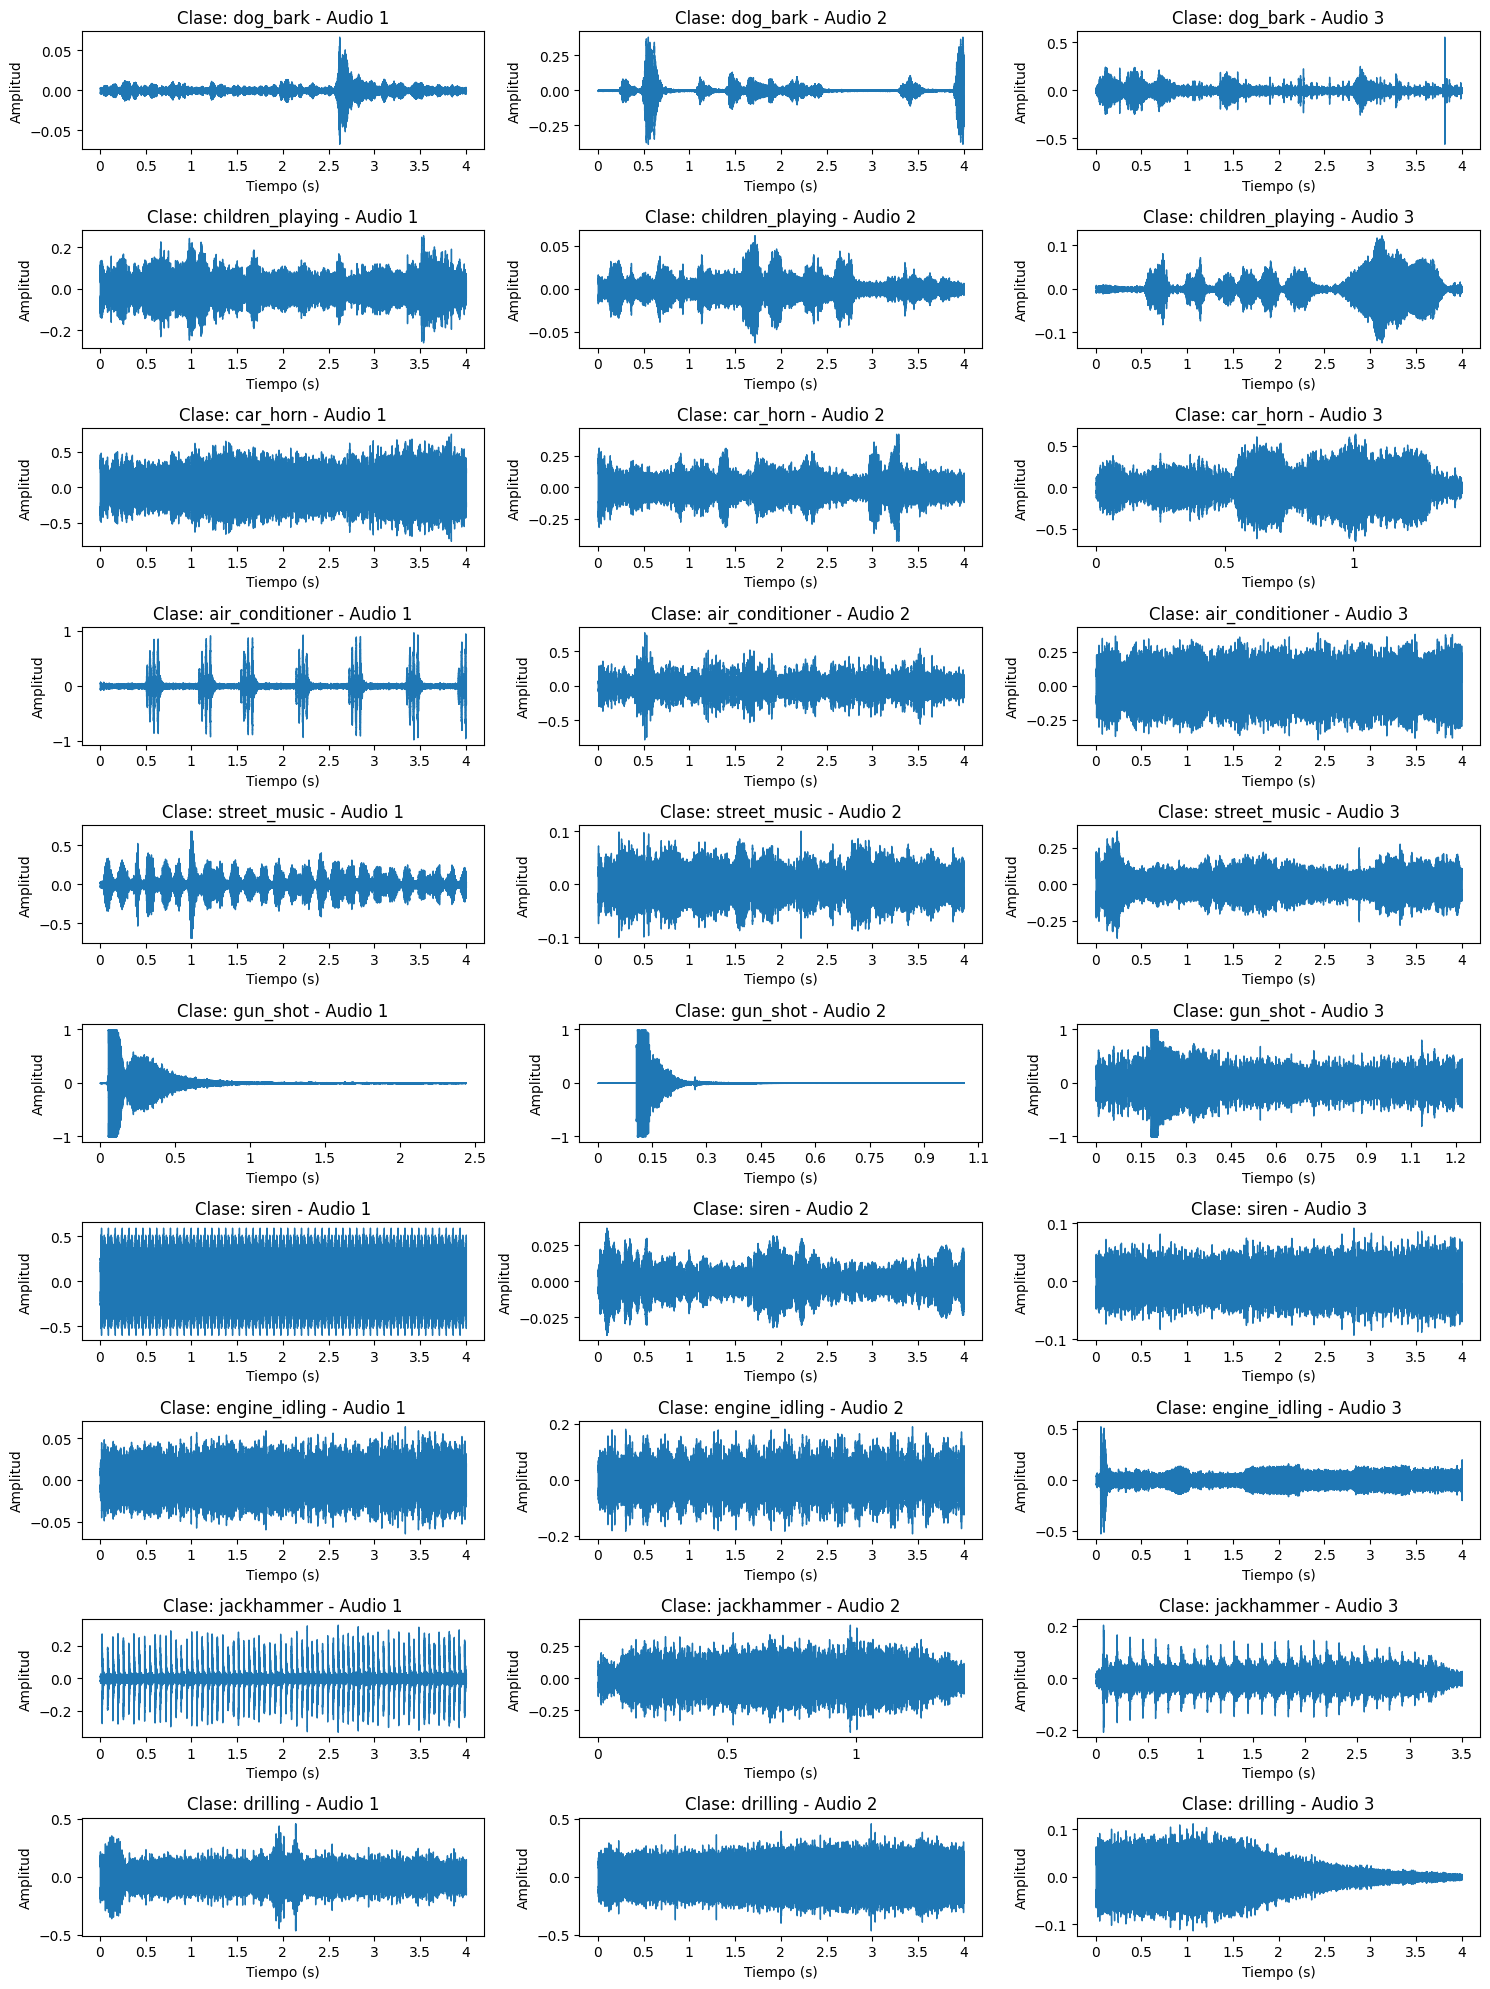

In [39]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado `metadata_urbansound8k_df`
# con las columnas 'class' y 'file_path', donde 'file_path' es la ruta del archivo de audio

# Obtener las clases únicas
clases_unicas = dataset_urbansound8k_df['class'].unique()

# Establecer el número de muestras por clase
num_muestras_por_clase = 3

# Crear una figura y ejes para subplots
fig, axes = plt.subplots(nrows=len(clases_unicas), ncols=num_muestras_por_clase, figsize=(15, 20))
fig.tight_layout(pad=3.0)

# Recorrer cada clase
for i, clase in enumerate(clases_unicas):
    # Filtrar el DataFrame para obtener los archivos de la clase actual
    archivos_clase = dataset_urbansound8k_df[dataset_urbansound8k_df['class'] == clase]['path']
    
    # Seleccionar los primeros `num_muestras_por_clase` archivos
    archivos_seleccionados = archivos_clase.sample(n=num_muestras_por_clase, random_state=2)
    
    # Graficar las formas de onda
    for j, archivo in enumerate(archivos_seleccionados):
        signal, sr = librosa.load(archivo, sr=None)  # Cargar el archivo de audio
        
        # Graficar en la subfigura correspondiente
        ax = axes[i, j]
        librosa.display.waveshow(signal, sr=sr, ax=ax)
        ax.set_title(f'Clase: {clase} - Audio {j+1}')
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')

# Ajustar el layout para evitar superposición de títulos
plt.tight_layout()
plt.show()


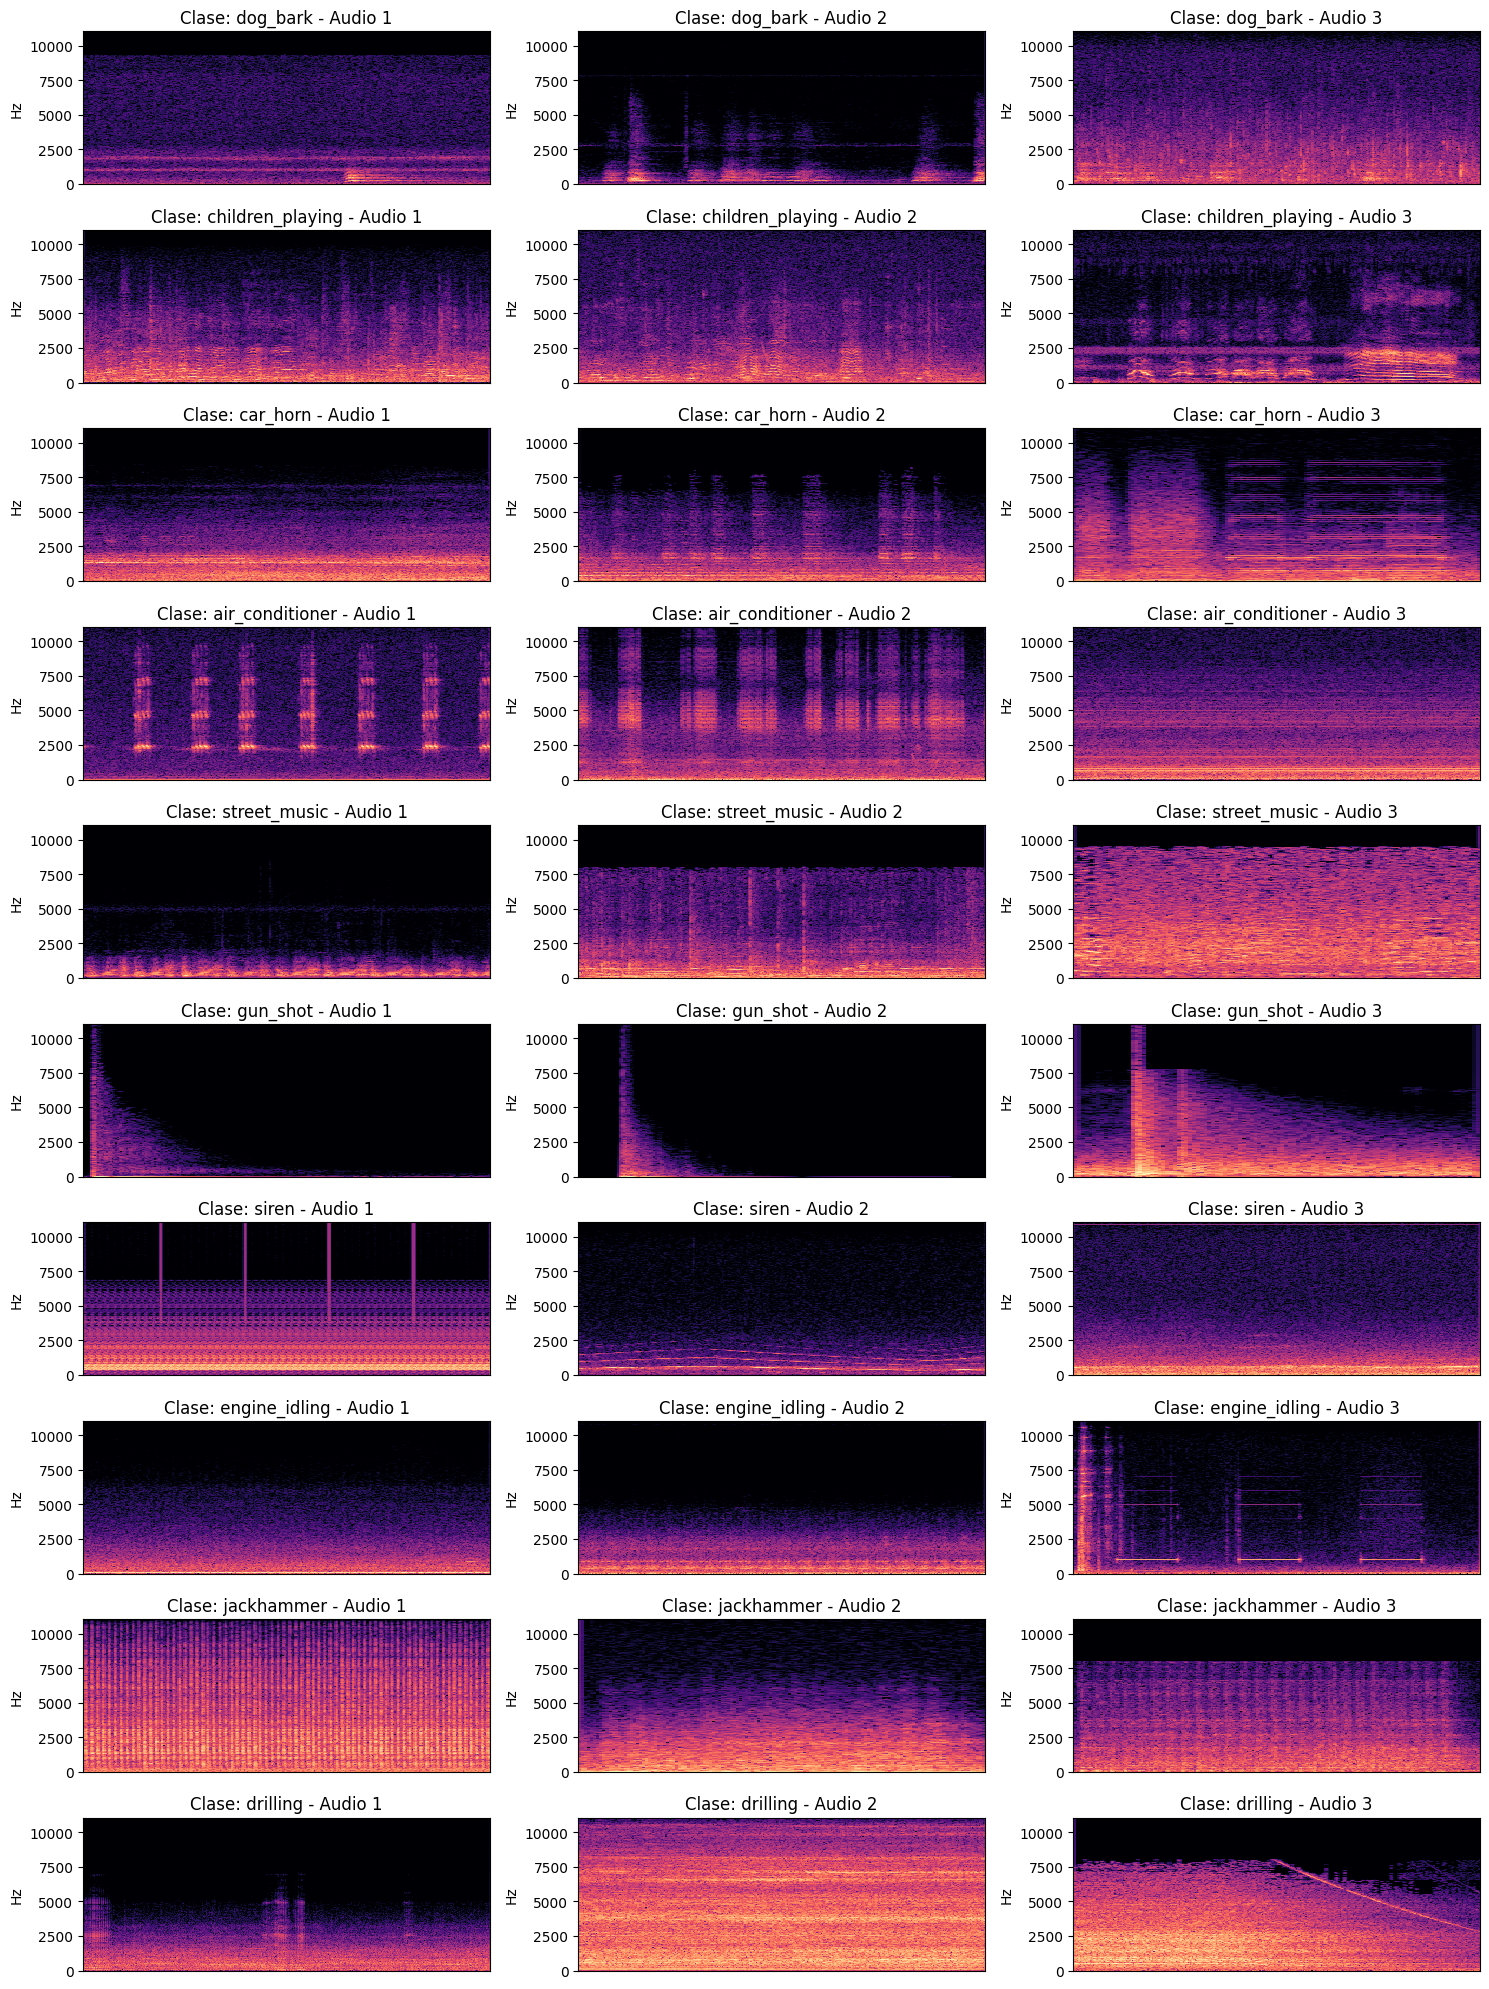

In [40]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado `metadata_urbansound8k_df`
# con las columnas 'class' y 'file_path', donde 'file_path' es la ruta del archivo de audio

# Obtener las clases únicas
clases_unicas = dataset_urbansound8k_df['class'].unique()

# Establecer el número de muestras por clase
num_muestras_por_clase = 3

# Crear una figura y ejes para subplots
fig, axes = plt.subplots(nrows=len(clases_unicas), ncols=num_muestras_por_clase, figsize=(15, 20))
fig.tight_layout(pad=3.0)

# Recorrer cada clase
for i, clase in enumerate(clases_unicas):
    # Filtrar el DataFrame para obtener los archivos de la clase actual
    archivos_clase = dataset_urbansound8k_df[dataset_urbansound8k_df['class'] == clase]['path']
    
    # Seleccionar los primeros `num_muestras_por_clase` archivos
    archivos_seleccionados = archivos_clase.sample(n=num_muestras_por_clase, random_state=2)
    
    # Graficar las formas de onda
    for j, archivo in enumerate(archivos_seleccionados):
        signal, sr = librosa.load(archivo, sr=None)  # Cargar el archivo de audio
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
        
        # Graficar en la subfigura correspondiente
        ax = axes[i, j]
        #librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', ax=ax)
        
        ax.set_title(f'Clase: {clase} - Audio {j+1}')
        #ax.set_xlabel('Tiempo (s)')
        #ax.set_ylabel('Amplitud')

# Ajustar el layout para evitar superposición de títulos
plt.tight_layout()
plt.show()


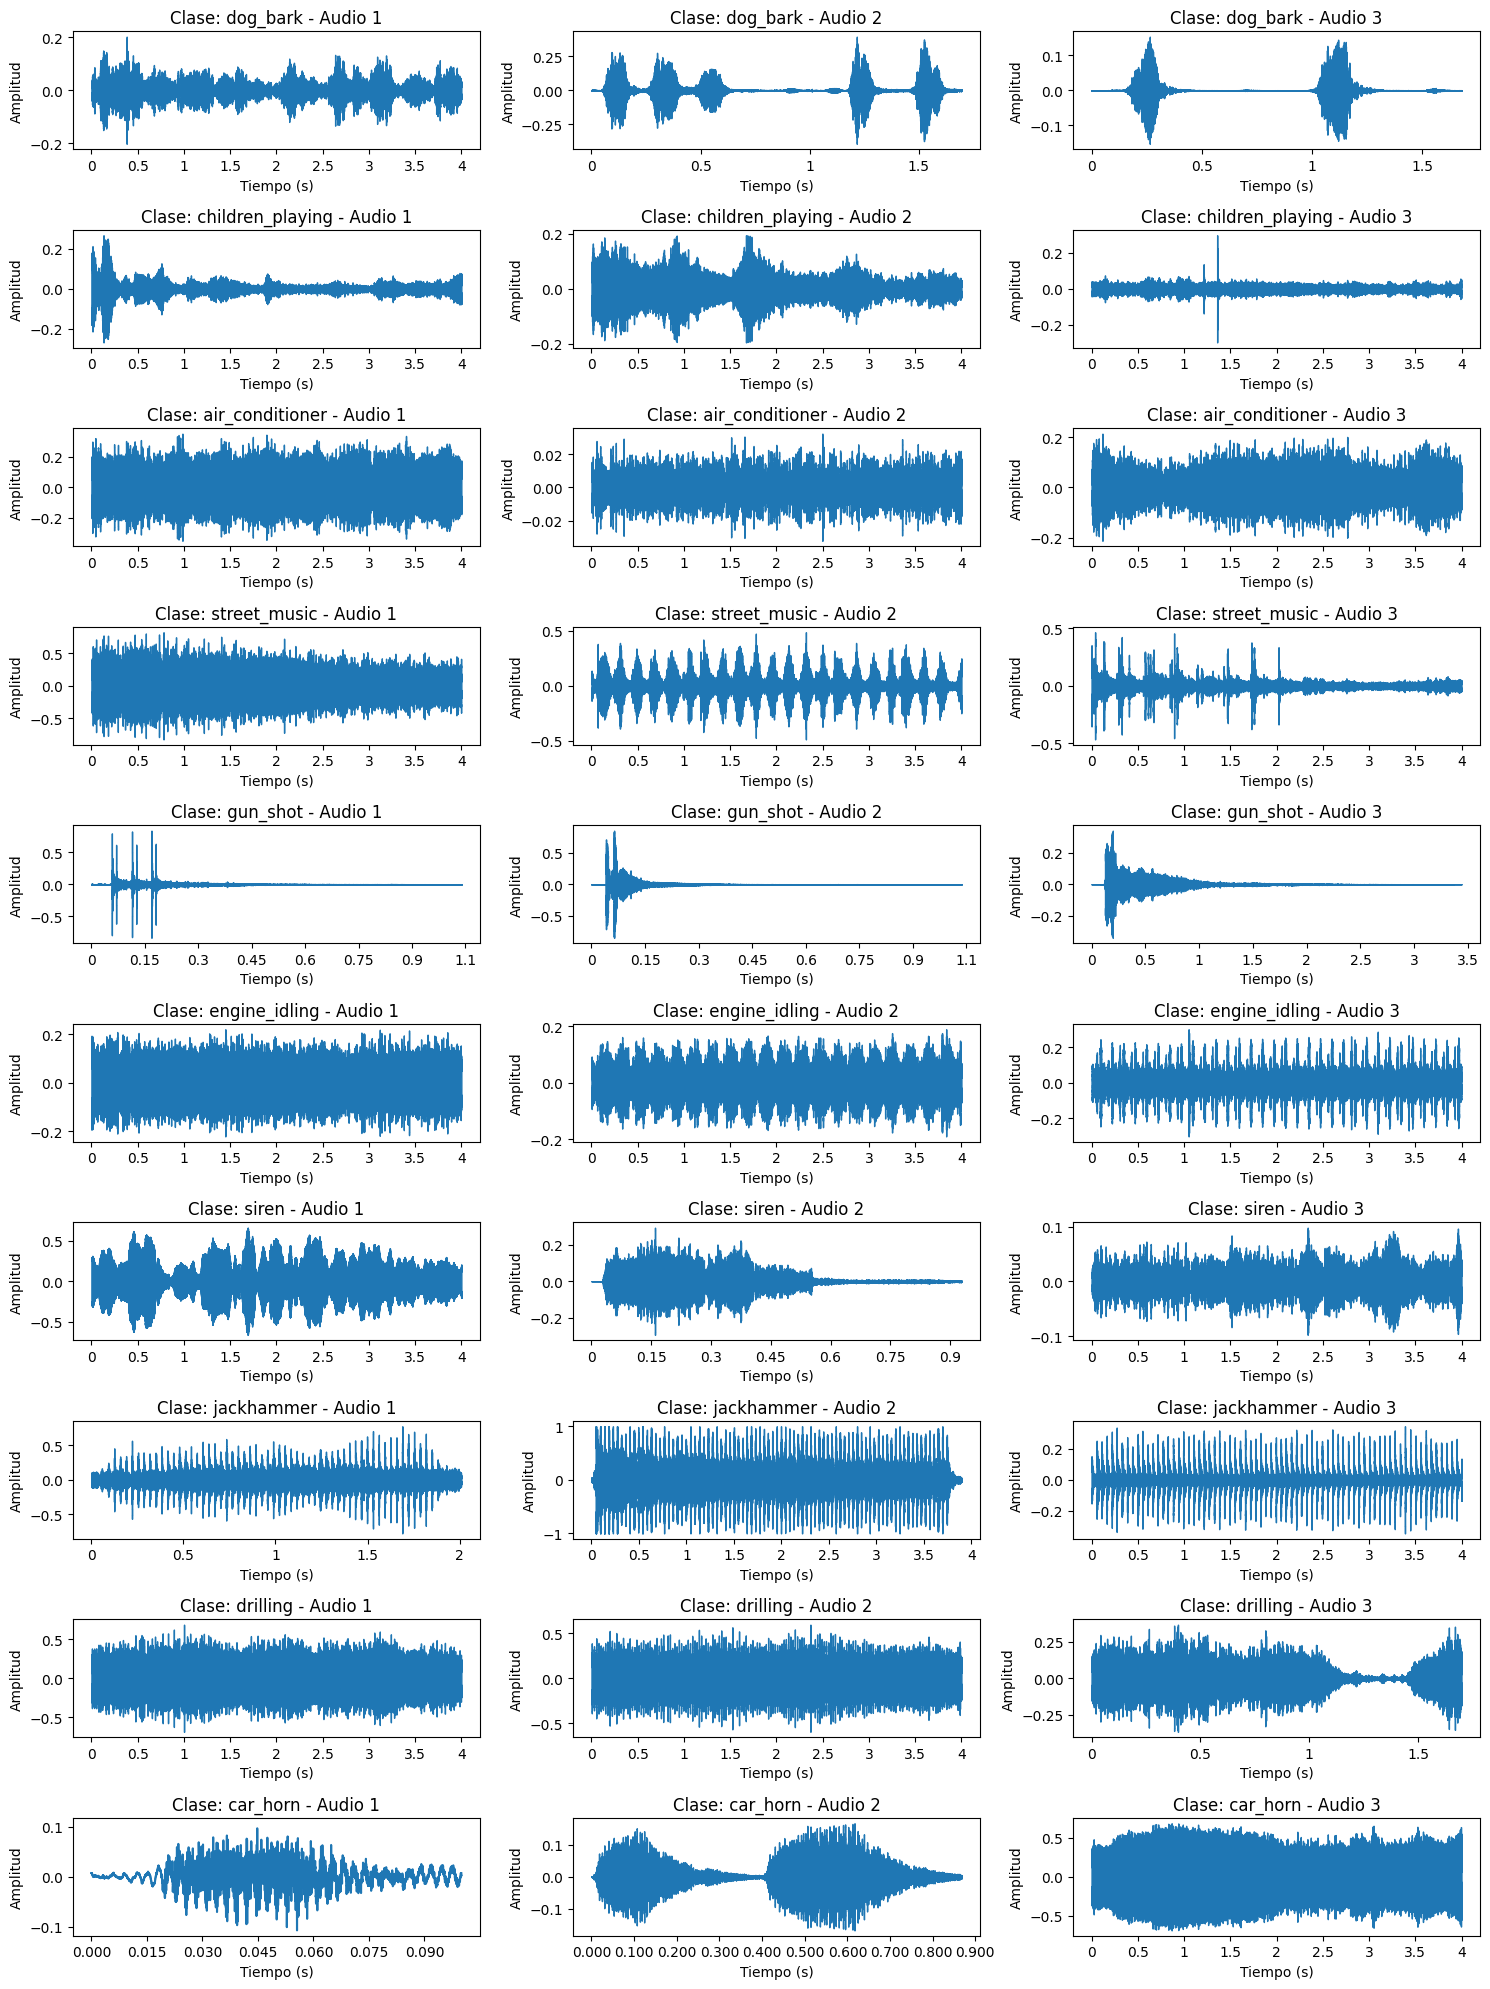

In [41]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado `metadata_urbansound8k_df`
# con las columnas 'class' y 'file_path', donde 'file_path' es la ruta del archivo de audio

dataset_urbansound8k_filtrado_df = dataset_urbansound8k_df[dataset_urbansound8k_df['salience']==1]
dataset_urbansound8k_filtrado_df.reset_index()

# Obtener las clases únicas
clases_unicas = dataset_urbansound8k_filtrado_df['class'].unique()

# Establecer el número de muestras por clase
num_muestras_por_clase = 3

# Crear una figura y ejes para subplots
fig, axes = plt.subplots(nrows=len(clases_unicas), ncols=num_muestras_por_clase, figsize=(15, 20))
fig.tight_layout(pad=3.0)

# Recorrer cada clase
for i, clase in enumerate(clases_unicas):
    # Filtrar el DataFrame para obtener los archivos de la clase actual
    archivos_clase = dataset_urbansound8k_filtrado_df[dataset_urbansound8k_filtrado_df['class'] == clase]['path']
    
    # Seleccionar los primeros `num_muestras_por_clase` archivos
    archivos_seleccionados = archivos_clase.sample(n=num_muestras_por_clase, random_state=2)
    
    # Graficar las formas de onda
    for j, archivo in enumerate(archivos_seleccionados):
        signal, sr = librosa.load(archivo, sr=None)  # Cargar el archivo de audio
        
        # Graficar en la subfigura correspondiente
        ax = axes[i, j]
        librosa.display.waveshow(signal, sr=sr, ax=ax)
        ax.set_title(f'Clase: {clase} - Audio {j+1}')
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')

# Ajustar el layout para evitar superposición de títulos
plt.tight_layout()
plt.show()

#### Correlacion Variables

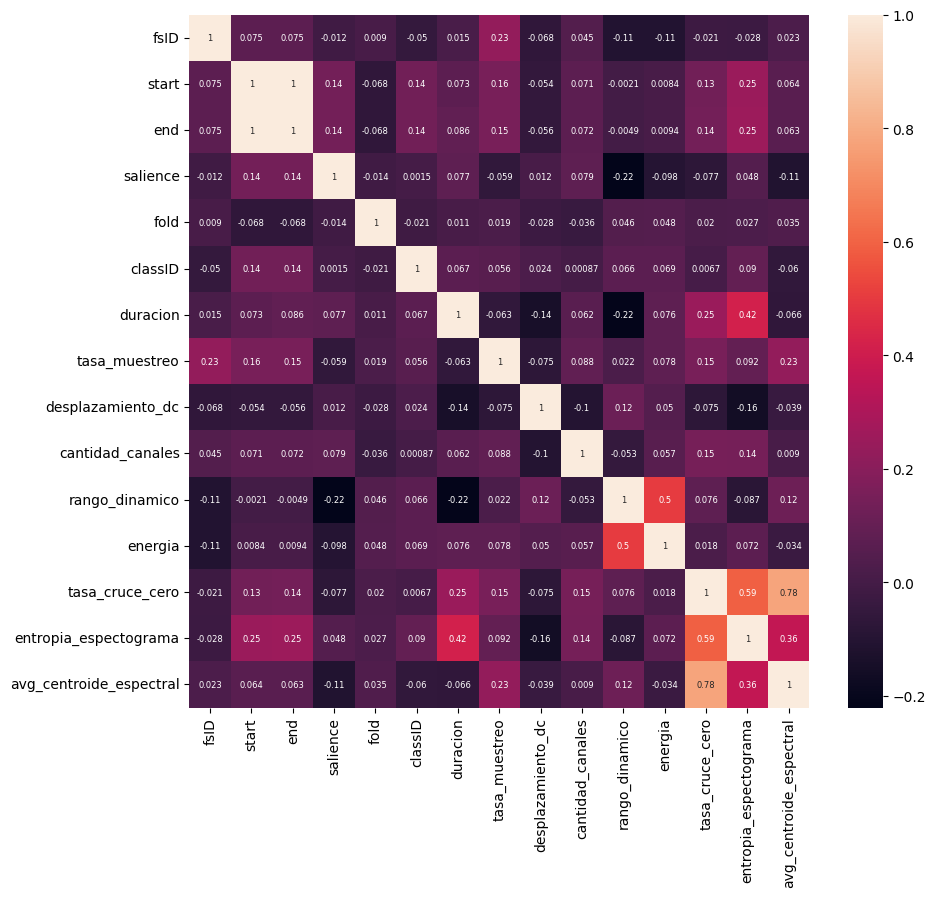

2024-08-21 10:11:57,442 - INFO     - Executing shutdown due to inactivity...
2024-08-21 10:12:13,729 - INFO     - Executing shutdown...
2024-08-21 10:12:13,729 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer
2024-08-21 10:12:14,042 - ERROR    - weakly-referenced object no longer exists
2024-08-21 10:12:14,043 - ERROR    - weakly-referenced object no longer exists
2024-08-21 10:12:14,047 - ERROR    - weakly-referenced object no longer exists
2024-08-21 10:12:14,048 - ERROR    - weakly-referenced object no longer exists
2024-08-21 10:12:14,049 - ERROR    - weakly-referenced object no longer exists
2024-08-21 10:12:14,050 - ERROR    - weakly-referenced object no longer exists
2024-08-21 10:12:14,052 - ERROR    - weakly-referenced object no longer exists
2024-08-21 10:12:14,053 - ERROR    - weakly-referenced object no longer exists
2024-08-21 10:12:14,054 - ERROR    - weakly-referenced object no longer exists
2024-08-21 10:12:14,054 - ERROR    

In [42]:
numeric_df = dataset_urbansound8k_df.select_dtypes(include=['float64', 'int64'])
correlacion_result = numeric_df.corr()
plt.figure(figsize=(10, 9))

sj_corr_heat = sns.heatmap(correlacion_result, annot=True, annot_kws={"size": 6})